# Experiment I
This is a experiment of the project *The Relation Between Date Implemented of Policies and The Spreading of COVID-19*. This is all the source code used in the first experiment.

## Preparing process

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import psycopg2
import pandas.io.sql as psql
import sqlalchemy

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Querying data from the database

In [2]:
# Reading database's information from the file
f = open('/content/db', 'r')
host = f.readline().strip()
dbname = f.readline().strip()
user = f.readline().strip()
password = f.readline().strip()
schema = f.readline().strip()
database = f.readline().strip()
f.close()

In [3]:
# Connect to database (Note: The package psychopg2 is required for Postgres to work with SQLAlchemy)
engine = sqlalchemy.create_engine("postgresql://{}:{}@{}/{}".format(user, password, host, database))
con = engine.connect()

In [4]:
noRecovDF = pd.read_sql("SELECT * FROM {}.{};".format(str(schema), "confirmed_no_recov"),
                        con=engine,
                        index_col="index")

In [5]:
noRecovDF.head()

,country_region,province_state,date,confirmed,deaths
index,,,,,
0,Afghanistan,-,2020-01-22,0,0
1,Albania,-,2020-01-22,0,0
2,Algeria,-,2020-01-22,0,0
3,Andorra,-,2020-01-22,0,0
4,Angola,-,2020-01-22,0,0


### Adapting data

In [6]:
noRecovDF.loc[noRecovDF.country_region == 'Taiwan*', 'country_region'] = 'Taiwan'

In [7]:
# Adding the incremental confirmed cases and deaths of each day
noRecovDF[['diff_confirmed', 'diff_deaths']] = noRecovDF[['country_region', 'province_state', 'confirmed', 'deaths']].groupby(['country_region', 'province_state']).diff()
noRecovDF = noRecovDF.fillna(0)
noRecovDF.loc[noRecovDF.diff_confirmed < 0, 'diff_confirmed'] = 0
noRecovDF.loc[noRecovDF.diff_deaths < 0, 'diff_deaths'] = 0
noRecovDF = noRecovDF[noRecovDF['country_region'] != 'Diamond Princess']

In [8]:
noRecovDF = pd.merge(noRecovDF, noRecovDF[noRecovDF['confirmed'] >= 100].groupby(['country_region', 'province_state']).first().date.reset_index(name='start_date'), on=['country_region', 'province_state'])

In [9]:
# Only looking at those countries when it hits 100 confirmed cases
noRecovDF = noRecovDF[noRecovDF['confirmed'] >= 100].reset_index().drop(columns='index')

In [10]:
# Adding the max and min of confirmed cases and deaths of each country
noRecovDF[['peak_confirmed', 'peak_deaths']] = noRecovDF.groupby(['country_region', 'province_state'])[['diff_confirmed', 'diff_deaths']].transform(max)
noRecovDF = pd.merge(noRecovDF, noRecovDF[noRecovDF.diff_confirmed > 0].groupby(['country_region', 'province_state']).min()['diff_confirmed'].rename('min_confirmed'), on=['country_region', 'province_state'])

In [11]:
# Change column date to datetime
noRecovDF['date'] = pd.to_datetime(noRecovDF['date'])

In [12]:
temp = noRecovDF[noRecovDF['diff_confirmed'] == noRecovDF['peak_confirmed']].groupby(['country_region', 'province_state']).last()['date'].reset_index(name='date_peak_confirmed')
noRecovDF = noRecovDF.merge(temp, on=['country_region', 'province_state'])
temp = noRecovDF[noRecovDF['diff_deaths'] == noRecovDF['peak_deaths']].groupby(['country_region', 'province_state']).last()['date'].reset_index(name='date_peak_deaths')
noRecovDF = noRecovDF.merge(temp, on=['country_region', 'province_state'])
temp = noRecovDF[noRecovDF['diff_confirmed'] == noRecovDF['min_confirmed']].groupby(['country_region', 'province_state']).last()['date'].reset_index(name='date_min_confirmed')
noRecovDF = noRecovDF.merge(temp, on=['country_region', 'province_state'])
noRecovDF[['before_peak_confirmed']] = noRecovDF[(noRecovDF.date_peak_confirmed - timedelta(days=8) > noRecovDF.date) | (noRecovDF.date_peak_confirmed + timedelta(days=8) < noRecovDF.date)].groupby(['country_region', 'province_state'])[['diff_confirmed']].transform(max)
temp = noRecovDF[noRecovDF['diff_confirmed'] == noRecovDF['before_peak_confirmed']].groupby(['country_region', 'province_state']).first()['date'].reset_index(name='date_before_peak_confirmed')
noRecovDF = noRecovDF.merge(temp, on=['country_region', 'province_state'])

### Create Country Profiles

In [13]:
noRecovDF.head()

,country_region,province_state,date,confirmed,deaths,diff_confirmed,diff_deaths,start_date,peak_confirmed,peak_deaths,min_confirmed,date_peak_confirmed,date_peak_deaths,date_min_confirmed,before_peak_confirmed,date_before_peak_confirmed
0,Afghanistan,-,2020-03-27,110,4,16.0,0.0,2020-03-27,915.0,30.0,4.0,2020-06-05,2020-06-07,2020-03-31,782.0,2020-05-23
1,Afghanistan,-,2020-03-28,110,4,0.0,0.0,2020-03-27,915.0,30.0,4.0,2020-06-05,2020-06-07,2020-03-31,782.0,2020-05-23
2,Afghanistan,-,2020-03-29,120,4,10.0,0.0,2020-03-27,915.0,30.0,4.0,2020-06-05,2020-06-07,2020-03-31,782.0,2020-05-23
3,Afghanistan,-,2020-03-30,170,4,50.0,0.0,2020-03-27,915.0,30.0,4.0,2020-06-05,2020-06-07,2020-03-31,782.0,2020-05-23
4,Afghanistan,-,2020-03-31,174,4,4.0,0.0,2020-03-27,915.0,30.0,4.0,2020-06-05,2020-06-07,2020-03-31,782.0,2020-05-23


In [14]:
lastweek = (datetime(2020, 6, 7) - timedelta(days=7))

feature1 = noRecovDF.groupby(['country_region', 'province_state']).size().reset_index(name='days')
feature2 = noRecovDF.groupby(['country_region', 'province_state']).last()[['confirmed', 'deaths', 'peak_confirmed', 'peak_deaths', 'start_date']]
feature3 = noRecovDF.groupby(['country_region', 'province_state']).mean()
feature4 = noRecovDF[noRecovDF['date'] >= pd.to_datetime(lastweek)].groupby(['country_region', 'province_state']).mean()
feature5 = noRecovDF[noRecovDF['date'] >= noRecovDF['date_peak_confirmed']].groupby(['country_region', 'province_state']).size().reset_index(name='after_peak')
feature6 = noRecovDF[noRecovDF['date'] >= noRecovDF['date_min_confirmed']].groupby(['country_region', 'province_state']).size().reset_index(name='after_min')
feature7 = noRecovDF[noRecovDF['date'] >= noRecovDF['date_before_peak_confirmed']].groupby(['country_region', 'province_state']).size().reset_index(name='after_expeak')
feature8 = noRecovDF[(noRecovDF['date'] >= noRecovDF['date_peak_confirmed'] - timedelta(days=7)) & (noRecovDF['date'] <= noRecovDF['date_peak_confirmed'])]\
            .groupby(['country_region', 'province_state']).mean()['diff_confirmed']
feature9 = noRecovDF[(noRecovDF['date'] >= noRecovDF['date_peak_deaths'] - timedelta(days=7)) & (noRecovDF['date'] <= noRecovDF['date_peak_deaths'])]\
            .groupby(['country_region', 'province_state']).mean()['diff_deaths']
feature10 = noRecovDF[(noRecovDF['date'] >= noRecovDF['date_min_confirmed'] - timedelta(days=7)) & (noRecovDF['date'] <= noRecovDF['date_min_confirmed'])]\
            .groupby(['country_region', 'province_state']).mean()['diff_confirmed']
feature11 = noRecovDF[(noRecovDF['date'] >= noRecovDF['date_before_peak_confirmed'] - timedelta(days=7)) & (noRecovDF['date'] <= noRecovDF['date_before_peak_confirmed'])]\
            .groupby(['country_region', 'province_state']).mean()['diff_confirmed']

In [15]:
df = feature2.merge(feature1, on=['country_region', 'province_state'])
df = df.merge(feature3[['diff_confirmed', 'diff_deaths']], on=['country_region', 'province_state'])
df = df.merge(feature4[['diff_confirmed', 'diff_deaths']], on=['country_region', 'province_state'])
df = df.merge(feature5, on=['country_region', 'province_state'])
df = df.merge(feature6, on=['country_region', 'province_state'])
df = df.merge(feature7, on=['country_region', 'province_state'])
df = df.merge(feature8, on=['country_region', 'province_state'])
df = df.merge(feature9, on=['country_region', 'province_state'])
df = df.merge(feature10, on=['country_region', 'province_state'])
df = df.merge(feature11, on=['country_region', 'province_state'])

In [16]:
df['death_rate'] = df['deaths'] / df['confirmed']

df.columns = ['country_region', 'province_state', 'confirmed', 'deaths',
                    'peak_confirmed', 'peak_deaths', 'start_date', 'days',
                    'avg_confirmed', 'avg_deaths', 'c_thisweek', 'd_thisweek', 
                    'after_peak', 'after_min', 'after_expeak', 'c_maxweek', 
                    'd_maxweek', 'c_minweek', 'c_beforemax', 'death_rate']

df['c_thisweek/avg'] = df['c_thisweek'] / df['avg_confirmed']
df['d_thisweek/avg'] = df['d_thisweek'] / df['avg_deaths']
df['c_thisweek/peakweek'] = df['c_thisweek'] / df['c_maxweek']
df['d_thisweek/peakweek'] = df['d_thisweek'] / df['d_maxweek']
df['c_thisweek/beforemax'] = df['c_thisweek'] / df['c_beforemax']
profiles = df.fillna(0)

In [17]:
profiles.head()

,country_region,province_state,confirmed,deaths,peak_confirmed,peak_deaths,start_date,days,avg_confirmed,avg_deaths,c_thisweek,d_thisweek,after_peak,after_min,after_expeak,c_maxweek,d_maxweek,c_minweek,c_beforemax,death_rate,c_thisweek/avg,d_thisweek/avg,c_thisweek/peakweek,d_thisweek/peakweek,c_thisweek/beforemax
0,Afghanistan,-,20342,357,915.0,30.0,2020-03-27,73,277.369863,4.835616,727.125,13.500,3,69,16,741.625,13.500,16.000000,493.125000,0.017550,2.621500,2.791785,0.980448,1.000000,1.474525
1,Albania,-,1246,34,34.0,4.0,2020-03-23,77,15.025974,0.415584,15.500,0.125,44,20,65,21.625,1.375,9.625000,18.375000,0.027287,1.031547,0.300781,0.716763,0.090909,0.843537
2,Algeria,-,10154,707,199.0,30.0,2020-03-21,79,127.392405,8.810127,110.875,7.625,40,77,22,129.625,22.125,46.666667,182.625000,0.069628,0.870342,0.865481,0.855352,0.344633,0.607118
3,Andorra,-,852,51,79.0,4.0,2020-03-22,78,9.794872,0.653846,11.000,0.000,6,4,73,10.125,1.375,11.125000,29.833333,0.059859,1.123037,0.000000,1.086420,0.000000,0.368715
4,Argentina,-,22794,664,983.0,25.0,2020-03-20,80,283.712500,8.262500,822.500,17.000,2,79,11,825.125,13.500,30.500000,677.375000,0.029130,2.899062,2.057489,0.996819,1.259259,1.214246


## Clustering

In [18]:
newDF = profiles.groupby(['country_region', 'province_state'])\
        ['days', 'after_peak', 'c_thisweek/avg', 'c_thisweek/peakweek']\
        .last()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


#### Rescaling features

In [19]:
newDF['after_peak'] = newDF['after_peak'].apply(np.log)
newDF['days'] = newDF['days'].apply(np.log)
# newDF['confirmed'] = newDF['confirmed'].apply(np.log10)
# newDF['after_peak'] = newDF['after_peak'] / newDF['days']
# newDF['after_min'] = newDF['after_min'] / newDF['days']
# newDF['after_expeak'] = newDF['after_expeak'] / newDF['days']
# newDF['after_min'] = newDF['after_min'].apply(np.log)
# newDF['after_expeak'] = newDF['after_expeak'].apply(np.log)
# newDF = newDF.drop(columns='days')

In [20]:
newDF

,,days,after_peak,c_thisweek/avg,c_thisweek/peakweek
country_region,province_state,,,,
Afghanistan,-,4.290459,1.098612,2.621500,0.980448
Albania,-,4.343805,3.784190,1.031547,0.716763
Algeria,-,4.369448,3.688879,0.870342,0.855352
Andorra,-,4.356709,1.791759,1.123037,1.086420
Argentina,-,4.382027,0.693147,2.899062,0.996819
...,...,...,...,...,...
Vietnam,-,4.356709,3.218876,0.123418,0.073171
West Bank and Gaza,-,4.262680,4.189655,0.593249,0.195312
Yemen,-,3.178054,1.791759,1.308271,1.048193


### Silhouettle Score
This process might take a few seconds since I use forloop to generate the average score of Silhouette.

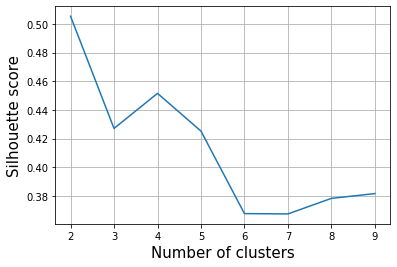

In [21]:
mms = MinMaxScaler()
scaled = pd.DataFrame(mms.fit_transform(newDF),
                      columns=newDF.columns,
                      index=newDF.index)

value = {}
for i in range(10):
  w = []
  for k in np.arange(2, 10, 1):
    model = KMeans(n_clusters=k, n_jobs=-1).fit(scaled)
    preds = model.predict(scaled)
    silhouette = silhouette_score(scaled, preds)
    w.append(silhouette)
    if i == 0:
      value[k] = silhouette
    else:
      value[k] = (value[k] * i + silhouette) / (i + 1)
w = [x[1] for x in value.items()]
  
plt.plot(np.arange(2, 10, 1), w)
plt.ylabel('Silhouette score', fontsize=15)
plt.xlabel('Number of clusters', fontsize=15)
plt.grid()
plt.savefig('silhouettle.png')

In [22]:
print('Scores:')
{k: v for k, v in sorted(value.items(), key=lambda item: item[1])}

Scores:


{2: 0.5052970884220224,
 3: 0.4270895429070098,
 4: 0.45155571852251575,
 5: 0.425238041569001,
 6: 0.3677361399936962,
 7: 0.36752270755960254,
 8: 0.37836346360995843,
 9: 0.3816877978572896}

### K-Mean

#### Selecting the number of clusters

In [23]:
n_clusters = 4

In [24]:
cls = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=42)
cls.fit(scaled)

model = KMeans(n_clusters=n_clusters).fit(scaled)
cluster = scaled.copy()
cluster['CLUSTER'] = cls.labels_

#### Heatmap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


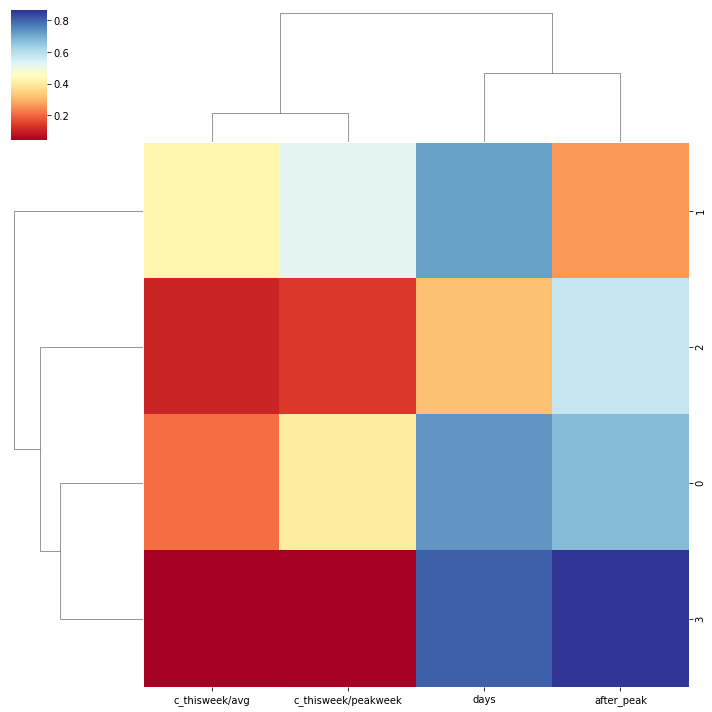

In [25]:
centroid = pd.DataFrame(model.cluster_centers_, columns=scaled.columns)
import seaborn as sns
# sns.set(font_scale=1.5)
map = sns.clustermap(centroid, cmap='RdYlBu')
map.savefig('clustermap.png', dpi=400)
map

#### Clusters details

In [26]:
temp = profiles.merge(cluster['CLUSTER'], on=['country_region', 'province_state'])
fig = temp[cluster.columns]\
        .groupby("CLUSTER").mean()\
        .merge(
            cluster.groupby("CLUSTER").size().reset_index(name='Size'), 
            on=['CLUSTER'])

In [27]:
fig

,CLUSTER,days,after_peak,c_thisweek/avg,c_thisweek/peakweek,Size
0,0,72.500000,4.822581,2.338668,1.118818,62
1,1,73.868852,31.180328,1.148792,0.856508,61
2,2,89.428571,72.672269,0.249844,0.105809,119
3,3,28.500000,18.888889,0.583330,0.294252,18


In [28]:
columns = ['country_region', 'province_state'] + list(cluster.columns)
temp[temp.CLUSTER == 0][columns].head()

,country_region,province_state,days,after_peak,c_thisweek/avg,c_thisweek/peakweek,CLUSTER
0,Afghanistan,-,73,3,2.621500,0.980448,0
3,Andorra,-,78,6,1.123037,1.086420,0
4,Argentina,-,80,2,2.899062,0.996819,0
5,Armenia,-,81,1,3.261948,1.000000,0
14,Azerbaijan,-,74,2,2.860556,1.025333,0


## Measures

In [29]:
measuresDF = pd.read_sql("SELECT * FROM {}.{};".format(str(schema), "measures"),
                         con=engine,
                         index_col="index")

In [30]:
measuresDF.loc[measuresDF.COUNTRY == 'China, Hong Kong Special Administrative Region', 'ADMIN_LEVEL_NAME'] = 'Hong Kong'
measuresDF.loc[measuresDF.COUNTRY == 'China, Hong Kong Special Administrative Region', 'COUNTRY'] = 'China'
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('city', '')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('province', '')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Province', '')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('ACT', 'Australian Capital Territory')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('NSW', 'New South Wales')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Qld', 'Queensland')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('SA', 'South Australia')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Tas', 'Tasmania')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Vic', 'Victoria')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('WA', 'Western Australia')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Chongquing', 'Chongqing')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.replace('Wuhan', 'Hubei')

measuresDF.COUNTRY = measuresDF.COUNTRY.str.replace('United States', 'US')
measuresDF.ADMIN_LEVEL_NAME = measuresDF.ADMIN_LEVEL_NAME.str.strip()

In [31]:
for state in list(profiles[profiles.country_region == 'Australia'].groupby('province_state').groups.keys()):
  measuresDF = measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == '-') & (measuresDF.COUNTRY == 'Australia')].assign(ADMIN_LEVEL_NAME=state))

for province in list(profiles[profiles.country_region == 'China'].groupby('province_state').groups.keys()):
  measuresDF = measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == '-') & (measuresDF.COUNTRY == 'China')].assign(ADMIN_LEVEL_NAME=province))

for state in list(profiles[profiles.country_region == 'US'].groupby('province_state').groups.keys()):
  measuresDF = measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == '-') & (measuresDF.COUNTRY == 'US')].assign(ADMIN_LEVEL_NAME=state))

for province in list(profiles[profiles.country_region == 'Canada'].groupby('province_state').groups.keys()):
  measuresDF = measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == '-') & (measuresDF.COUNTRY == 'Canada')].assign(ADMIN_LEVEL_NAME=province))

for state in ['New South Wales', 'Victoria', 'Australian Capital Territory']:
  measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == 'New South Wales, Victoria, Australian Capital Territory') & (measuresDF.COUNTRY == 'Australia')].assign(ADMIN_LEVEL_NAME=state))

for state in ['South Australia', 'Western Australia', 'Tasmania']:
  measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == 'South Australia, Western Australia, Tasmania, NT') & (measuresDF.COUNTRY == 'Australia')].assign(ADMIN_LEVEL_NAME=state))

for state in ['Victoria', 'Australian Capital Territory']:
  measuresDF.append(measuresDF[(measuresDF.ADMIN_LEVEL_NAME == 'Victoria, Australian Capital Territory') & (measuresDF.COUNTRY == 'Australia')].assign(ADMIN_LEVEL_NAME=state))

measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != 'New South Wales, Victoria, Australian Capital Territory') | (measuresDF.COUNTRY != 'Australia')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != 'South Australia, Western Australia, Tasmania, NT') | (measuresDF.COUNTRY != 'Australia')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != 'Victoria, Australian Capital Territory') | (measuresDF.COUNTRY != 'Australia')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != '-') | (measuresDF.COUNTRY != 'Australia')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != '-') | (measuresDF.COUNTRY != 'China')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != '-') | (measuresDF.COUNTRY != 'US')]
measuresDF = measuresDF[(measuresDF.ADMIN_LEVEL_NAME != '-') | (measuresDF.COUNTRY != 'Canada')]

In [32]:
df = measuresDF[measuresDF.LOG_TYPE != 'Phase-out measure'].pivot_table(values='DATE_IMPLEMENTED', index=['COUNTRY', 'ADMIN_LEVEL_NAME'], columns='MEASURE', aggfunc='first').fillna('-').reset_index()

In [33]:
df = df[df['ADMIN_LEVEL_NAME'] != 'King & Flinders Islands']
df = df[df['ADMIN_LEVEL_NAME'] != 'Beijing\'s Chaoyang district']
df = df[df['ADMIN_LEVEL_NAME'] != 'City of Suifenhe, Heilongjiang']
df = df[df['ADMIN_LEVEL_NAME'] != 'Calais and Dunkirk']
df = df[df['ADMIN_LEVEL_NAME'] != 'Bilda + Algiers']
df = df[df['ADMIN_LEVEL_NAME'] != 'Clark County, NV']
df = df[df['ADMIN_LEVEL_NAME'] != 'NT']
df = df[df['ADMIN_LEVEL_NAME'] != 'Shulan']
df = df[df['ADMIN_LEVEL_NAME'] != 'Guangzhou']

In [34]:
df.loc[df.COUNTRY == 'Thailand', 'lockdown'] = datetime(2020, 3, 22)
measuresDF = df

In [35]:
measuresDF.head()

MEASURE,COUNTRY,ADMIN_LEVEL_NAME,additional health/documents requirements upon arrival,amendments to funeral and burial regulations,awareness campaigns,border checks,border closure,changes in prison-related policies,checkpoints within the country,closure of businesses and public services,complete border closure,curfews,domestic travel restrictions,economic measures,emergency administrative structures activated or established,general recommendations,health screenings in airports and border crossings,humanitarian exemptions,international flights suspension,isolation and quarantine policies,limit product imports/exports,limit public gatherings,lockdown,lockdown of refugee/idp camps or other minorities,mass population testing,military deployment,other public health measures enforced,psychological assistance and medical social work,requirement to wear protective gear in public,schools closure,state of emergency declared,strengthening the public health system,surveillance and monitoring,testing policy,visa restrictions
0,Afghanistan,-,-,-,2020-01-24 00:00:00,2020-02-01 00:00:00,2020-02-24 00:00:00,2020-03-31 00:00:00,-,-,-,-,2020-02-24 00:00:00,-,2020-02-06 00:00:00,2020-02-24 00:00:00,2020-01-26 00:00:00,-,2020-01-27 00:00:00,2020-02-02 00:00:00,2020-03-01 00:00:00,2020-03-12 00:00:00,-,-,-,-,2020-02-20 00:00:00,-,-,2020-03-15 00:00:00,2020-03-20 00:00:00,2020-02-04 00:00:00,2020-02-13 00:00:00,-,-
1,Albania,-,-,-,2020-03-11 00:00:00,-,2020-03-14 00:00:00,2020-03-23 00:00:00,2020-03-10 00:00:00,2020-03-10 00:00:00,-,2020-03-23 00:00:00,2020-03-13 00:00:00,2020-03-10 00:00:00,2020-03-22 00:00:00,2020-03-22 00:00:00,2020-03-19 00:00:00,-,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-08 00:00:00,2020-03-08 00:00:00,2020-04-02 00:00:00,-,-,2020-03-11 00:00:00,2020-01-24 00:00:00,-,-,2020-03-10 00:00:00,2020-04-30 00:00:00,2020-01-24 00:00:00,2020-04-13 00:00:00,-,-
2,Algeria,-,-,-,2020-03-05 00:00:00,2020-03-12 00:00:00,2020-03-17 00:00:00,-,-,2020-03-16 00:00:00,-,2020-03-23 00:00:00,2020-03-22 00:00:00,-,-,-,-,-,2020-03-20 00:00:00,2020-03-18 00:00:00,-,2020-03-12 00:00:00,2020-04-05 00:00:00,-,-,2020-03-23 00:00:00,-,-,2020-05-23 00:00:00,2020-03-12 00:00:00,-,-,-,-,-
3,Angola,-,2020-04-09 00:00:00,-,2020-03-11 00:00:00,-,2020-03-27 00:00:00,2020-04-02 00:00:00,-,2020-03-27 00:00:00,-,-,2020-03-27 00:00:00,2020-03-26 00:00:00,2020-04-06 00:00:00,2020-03-22 00:00:00,2020-03-03 00:00:00,-,2020-03-20 00:00:00,2020-02-06 00:00:00,2020-03-27 00:00:00,2020-04-04 00:00:00,2020-04-26 00:00:00,2020-03-26 00:00:00,2020-04-27 00:00:00,-,2020-05-26 00:00:00,-,2020-04-16 00:00:00,2020-03-23 00:00:00,2020-03-27 00:00:00,2020-03-26 00:00:00,2020-05-02 00:00:00,2020-05-09 00:00:00,2020-03-01 00:00:00
4,Antigua and Barbuda,-,-,2020-03-28 00:00:00,2020-03-03 00:00:00,-,-,2020-03-28 00:00:00,-,2020-03-25 00:00:00,-,2020-03-28 00:00:00,-,2020-03-16 00:00:00,2020-03-16 00:00:00,-,-,-,-,-,-,2020-03-16 00:00:00,2020-04-02 00:00:00,-,-,-,2020-03-28 00:00:00,-,2020-03-28 00:00:00,2020-03-15 00:00:00,2020-03-28 00:00:00,2020-02-12 00:00:00,-,-,-


## Correlations

### Preprocessing

In [36]:
corDF = temp.merge(df, 
                   left_on=['country_region', 'province_state'], 
                   right_on=['COUNTRY', 'ADMIN_LEVEL_NAME'], 
                   how='inner')\
            .drop(columns=['COUNTRY', 'ADMIN_LEVEL_NAME'])

In [37]:
corCol = list(corDF.columns[26:])
corDF[corCol] = corDF[corCol].apply(lambda x: np.where(x == '-', datetime(2019, 1, 1), x))

In [38]:
for measure in list(corDF.columns[26:]):
  corDF[measure] = (corDF[measure] - pd.to_datetime(corDF.start_date))

In [39]:
corDF[corCol] = corDF[corCol].astype(int) / 86400000000000

In [40]:
corDF[corCol] = corDF[corCol].apply(lambda x: np.where((x > -150) & (x < 0), np.round(-np.log(-x)), x))
corDF[corCol] = corDF[corCol].apply(lambda x: np.where(x < -150, float('NaN'), x))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
corDF['after_peak_r'] = corDF.days - corDF.after_peak
corDF['after_expeak_r'] = corDF.days - corDF.after_expeak

### Results

#### Correlation function

In [42]:
def getCorrelation (n, features, score):
  global corDF
  df = corDF[(corDF.CLUSTER == n)]
  df = df[(df.country_region != 'China') | (df.province_state == 'Hubei') | (df.province_state == 'Hong Kong')]
  df = df.dropna(thresh=len(df)/4, axis=1)
  colCor = list(df.columns[26:-2])
  lenColCor = len(list(df.columns[26:-2]))
  col = features
  correlation = df[col + colCor].corr().drop(columns=col)[:-lenColCor]
  return correlation.drop(columns=correlation.columns[(correlation.max() < score) & (correlation.min() > -score)], axis=1)

#### Correlation of policies and cluster #0

In [43]:
getCorrelation (0, ['after_peak_r', 'death_rate'], 0.5)

,isolation and quarantine policies,psychological assistance and medical social work,requirement to wear protective gear in public
after_peak_r,0.440507,0.705147,0.655447
death_rate,0.649389,0.649291,-0.004256


#### Correlation of policies and cluster #1

In [44]:
getCorrelation (1, ['after_peak_r', 'death_rate'], 0.4)

,curfews,domestic travel restrictions,international flights suspension,isolation and quarantine policies
after_peak_r,0.448319,0.544192,0.316410,0.519294
death_rate,-0.244856,0.054834,0.442516,-0.073200


#### Correlation of policies and cluster #2

In [45]:
getCorrelation (2, ['after_peak_r', 'death_rate'], 0.38)

,changes in prison-related policies,domestic travel restrictions,isolation and quarantine policies,requirement to wear protective gear in public
after_peak_r,0.488048,0.569322,0.232877,0.225269
death_rate,0.357419,0.334822,0.448394,0.389556


### Etc.

In [46]:
def getFeatureWithPolicy (n, feature, policy, ascending):
  df = corDF[(corDF.CLUSTER == n)]
  df = df[(df.country_region != 'China') | (df.province_state == 'Hubei') | (df.province_state == 'Hong Kong')]
  df = df.dropna(thresh=len(df)/4, axis=1)
  return df[~df[policy].isna()][['country_region', 'province_state', 'days', feature, policy]].sort_values(by='death_rate', ascending=ascending).head(50)

In [47]:
getFeatureWithPolicy(1, 'death_rate', 'psychological assistance and medical social work', False)

,country_region,province_state,days,death_rate,psychological assistance and medical social work
215,US,Ohio,81,0.061777,25.0
194,US,Indiana,80,0.056716,24.0
209,US,New Hampshire,77,0.056117,21.0
205,US,Missouri,78,0.055590,22.0
185,US,Colorado,86,0.054534,30.0
188,US,District of Columbia,78,0.052400,22.0
216,US,Oklahoma,76,0.050902,20.0
227,US,Washington,93,0.048843,37.0
200,US,Maryland,81,0.048091,25.0
204,US,Mississippi,79,0.047307,23.0
